In [3]:
# Set seeds
from numpy.random import seed
import tensorflow as tf
seed(42)
tf.random.set_seed(42)

In [4]:
pip install imbalanced-learn --upgrade

     |████████████████████████████████| 215kB 8.1MB/s 
     |████████████████████████████████| 22.3MB 63.2MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3


In [5]:
# Upgrade module imbalanced-learn to run on Google Colab
#!pip install imbalanced-learn --upgrade

# Import modules
import imblearn
import keras
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import sklearn

from google.colab import drive
from imblearn.over_sampling import RandomOverSampler
from keras.applications.resnet import ResNet50
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, History
from keras.layers import Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.metrics import categorical_accuracy
from keras.models import Sequential,Model,load_model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from numpy import expand_dims
from platform import python_version
from sklearn.model_selection import train_test_split

%matplotlib inline

# Versions
print("Version Python:",python_version())
print()
print("Version Imblearn:",imblearn.__version__)
print("Version Keras:",keras.__version__)
print("Version Matplotlib:",'3.8.3')
print("Version NumPy:",np.__version__)
print("Version Pandas:",pd.__version__)
print("Version Scikit-learn:",sklearn.__version__)
print("Version TensorFlow:",tf.__version__)

Version Python: 3.7.10

Version Imblearn: 0.8.0
Version Keras: 2.5.0
Version Matplotlib: 3.8.3
Version NumPy: 1.19.5
Version Pandas: 1.1.5
Version Scikit-learn: 0.24.2
Version TensorFlow: 2.5.0


In [6]:
# Set data folder and load dataframe
drive.mount('/content/drive')
data_folder = '/content/drive/MyDrive/'
data = pd.read_pickle(os.path.join(data_folder, 'data.pkl'))

Mounted at /content/drive


In [7]:
# Setting data augmentation parameters 
data_augmentation = ImageDataGenerator(
    rotation_range = 60,
    zoom_range = 0.2,  
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,  
    vertical_flip = True,  
    shear_range = 10) 

In [10]:
# Create training, validation amd test sets (Derived from: https://www.kaggle.com/kaimingk/skin-cancer-mnist-ham10000)

# Split 70%, 10%, 20%. Test and validation, together 30%, should be from unique ID's only
size_val_test = 0.3 * len(data)
val_test_ratio_from_unique = size_val_test/len(data[data.unique == True])

# Training data = remainder of unique ID's + non-uniques. Split is stratified by lesion type (benign/malignant)
bb_data_train_unique, bb_data_val_test = train_test_split(data[data["unique"] == True], test_size = val_test_ratio_from_unique, stratify=data[data["unique"] == True]["lesion_type_cat"], random_state = 42)
bb_data_train = pd.concat((bb_data_train_unique, data[data["unique"] == False]), axis = 0)

# Split validation and test sets. Split is stratified by lesion type (benign/malignant)
bb_data_validation, bb_data_test = train_test_split(bb_data_val_test, test_size = 0.6667, stratify=bb_data_val_test["lesion_type_cat"], random_state = 42)

# Class balancing (random oversampling)
X = bb_data_train.drop(['lesion_type_cat'], axis=1)
y = bb_data_train['lesion_type_cat']

X_test = bb_data_test.drop(['lesion_type_cat'], axis=1)
y_test = bb_data_test['lesion_type_cat']

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

ros = RandomOverSampler(random_state=42)
X_test_resampled, y_test_resampled = ros.fit_resample(X_test, y_test)

bb_data_train = pd.concat([X_resampled, y_resampled], axis=1)
bb_data_test = pd.concat([X_test_resampled, y_test_resampled], axis=1)

# Create variables for feature (x) and target (y) training, validation and test sets
bb_data_train_x = np.asarray(bb_data_train['image'].tolist())
bb_data_validation_x = np.asarray(bb_data_validation['image'].tolist())
bb_data_test_x = np.asarray(bb_data_test['image'].tolist())

bb_data_train_y = np.asarray(bb_data_train['lesion_type_cat'].tolist())
bb_data_validation_y = np.asarray(bb_data_validation['lesion_type_cat'].tolist())
bb_data_test_y = np.asarray(bb_data_test['lesion_type_cat'].tolist())

# One-hot encoding of target variable
bb_num_classes = len(np.sort(data['lesion_type_cat'].unique()))

bb_data_train_y = to_categorical(bb_data_train_y, num_classes = bb_num_classes)
bb_data_validation_y = to_categorical(bb_data_validation_y, num_classes = bb_num_classes)
bb_data_test_y = to_categorical(bb_data_test_y, num_classes = bb_num_classes)

In [11]:
# Fit data augmentation
data_augmentation.fit(bb_data_train_x)

In [12]:
# Creating ResNet model (Derived from: https://www.kaggle.com/jnegrini/ham10000-analysis-and-model-comparison)

# Model parameters
input_shape = (75, 100, 3)
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
epochs = 50
batch_size = 32

# Callbacks
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.5, min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=20,monitor='val_accuracy')
history = History()

# Define model architecture
base_model = ResNet50(include_top=False, input_shape=(75,100, 3),pooling = 'avg', weights = 'imagenet');

ResNet50model_binary = Sequential()
ResNet50model_binary.add(base_model)
ResNet50model_binary.add(Dropout(0.2))
ResNet50model_binary.add(Dense(128, activation="relu"))
ResNet50model_binary.add(Dropout(0.2))
ResNet50model_binary.add(Dense(bb_num_classes, activation = 'softmax'))
ResNet50model_binary.summary()

# Layers in ResNet are pretrained (ImageNet)
for layer in base_model.layers:
    layer.trainable = False

# Compile model
ResNet50model_binary.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 23,850,242
Trainable params: 23,797,122
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
# Fit and save model 
bb_history = ResNet50model_binary.fit(data_augmentation.flow(bb_data_train_x,bb_data_train_y, batch_size=batch_size),
                        epochs = epochs, validation_data = (bb_data_validation_x,bb_data_validation_y),
                        verbose = 1, steps_per_epoch=bb_data_train_x.shape[0] // batch_size, 
                        callbacks=[learning_rate_reduction,early_stopping_monitor, history])

ResNet50model_binary.save(os.path.join(data_folder,"Baseline_binary_model"))

Epoch 1/50
324/324 [==============================] - 79s 82ms/step - loss: 0.6458 - accuracy: 0.6732 - val_loss: 0.1924 - val_accuracy: 0.9068
Epoch 2/50
324/324 [==============================] - 22s 68ms/step - loss: 0.5085 - accuracy: 0.7422 - val_loss: 0.2278 - val_accuracy: 0.8842
Epoch 3/50
324/324 [==============================] - 22s 68ms/step - loss: 0.4924 - accuracy: 0.7371 - val_loss: 0.1873 - val_accuracy: 0.9037
Epoch 4/50
324/324 [==============================] - 22s 69ms/step - loss: 0.4808 - accuracy: 0.7553 - val_loss: 0.1829 - val_accuracy: 0.9037
Epoch 5/50
324/324 [==============================] - 22s 69ms/step - loss: 0.4870 - accuracy: 0.7517 - val_loss: 0.2258 - val_accuracy: 0.8904
Epoch 6/50
324/324 [==============================] - 21s 66ms/step - loss: 0.4752 - accuracy: 0.7601 - val_loss: 0.2675 - val_accuracy: 0.8658

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/50
324/324 [==============================] - 2

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Baseline_binary_model/assets


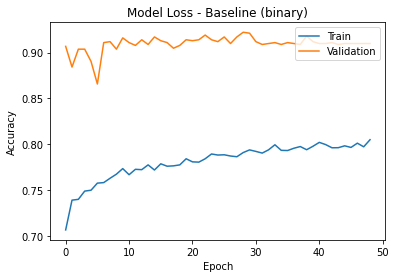

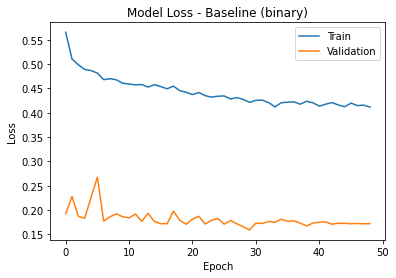

In [ ]:
# Accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Loss - Baseline (binary)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
filename = str('Model Accuracy - Baseline (binary).png')
plt.savefig(os.path.join(data_folder,filename), dpi=600)
plt.show()

# Loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss - Baseline (binary)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
filename = str('Model Loss - Baseline (binary).png')
plt.savefig(os.path.join(data_folder,filename), dpi=600)
plt.show()

In [ ]:
with open(os.path.join(data_folder, 'data_bb.pkl'), 'wb') as f:
    pickle.dump([bb_data_train_x,bb_data_validation_x,bb_data_test_x,bb_data_train_y,bb_data_validation_y,bb_data_test_y], f)